In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


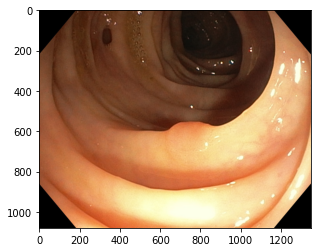

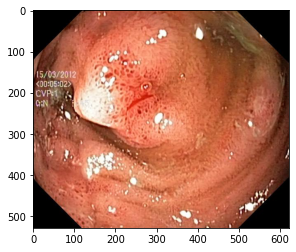

(1080, 1350, 3)
(529, 622, 3)
(529, 622, 3)


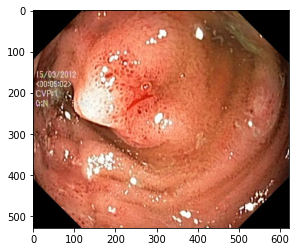

32512

In [ ]:
#Color Correction
#https://github.com/chia56028/Color-Transfer-between-Images/blob/master/color_transfer.py
import numpy as np
import cv2 
import os
from skimage.transform import resize
import matplotlib.pyplot as plt
from skimage import io

def read_file(source,target):
  source = io.imread(source)
  plt.imshow(source)
  plt.show()
  target = io.imread(target)
  plt.imshow(target)
  plt.show()
  print(source.shape)
  print(target.shape)
  img = cv2.resize(target, dsize = (622,529),interpolation=cv2.INTER_CUBIC)
  print(img.shape)
  #img = cv2.resize(source, output_shape=(500,1600,3), mode='constant', anti_aliasing=True)
  s = cv2.cvtColor(img,cv2.COLOR_BGR2LAB)
  t = cv2.cvtColor(target,cv2.COLOR_BGR2LAB)
  return s, t

def get_mean_and_std(x):
	x_mean, x_std = cv2.meanStdDev(x)
	x_mean = np.vstack(np.around(x_mean,2))
	x_std = np.vstack(np.around(x_std,2))
	return x_mean, x_std

def color_transfer():
  
  s, t = read_file('/content/drive/MyDrive/DivergentNets/divergent-nets-main/PolypGen2021_MultiCenterData/data_C1/images_C1/100H0050.jpg','/content/drive/MyDrive/DivergentNets/divergent-nets-main/Kvasir-Seg1/cju0qkwl35piu0993l0dewei2.jpg')
  s_mean, s_std = get_mean_and_std(s)
  t_mean, t_std = get_mean_and_std(t)
  height, width, channel = s.shape
  for i in range(0,height):
    for j in range(0,width):
      for k in range(0,channel):
        x = s[i,j,k]
        x = ((x-s_mean[k])*(t_std[k]/s_std[k]))+t_mean[k]
        s[i,j,k] = x
  s = cv2.cvtColor(s,cv2.COLOR_LAB2BGR)
  return s

s = color_transfer()
plt.imsave('./r'+'.jpg',s)
plt.imshow(s)
plt.show()
os.system("pause")



In [ ]:
#resizing images
from PIL import Image
img = Image.open('/content/test_0.jpg')
img = img.resize((622,529), Image.ANTIALIAS)
img.save(f'/content/drive/MyDrive/DivergentNets/divergent-nets-main/Imagetest/Masks/resized_image_mask519.jpg')

In [ ]:
#specularity removal
import cv2
import numpy as np

def derive_graym(impath):
    ''' The intensity value m is calculated as (r+g+b)/3, yet 
        grayscalse will do same operation!
        opencv uses default formula Y = 0.299 R + 0.587 G + 0.114 B
    '''
    # return cv2.imread(impath, cv2.CV_LOAD_IMAGE_GRAYSCALE)
    return cv2.imread(impath, cv2.IMREAD_GRAYSCALE)

def derive_m(img, rimg):
    ''' Derive m (intensity) based on paper formula '''

    (rw, cl, ch) = img.shape
    for r in range(rw):
        for c in range(cl):
            rimg[r,c] = int(np.sum(img[r,c])/3.0)
            
    return rimg

def derive_saturation(img, rimg):
    ''' Derive staturation value for a pixel based on paper formula '''

    s_img = np.array(rimg)
    (r, c) = s_img.shape
    for ri in range(r):
        for ci in range(c):
            #opencv ==> b,g,r order
            s1 = img[ri,ci][0] + img[ri,ci][2]
            s2 = 2 * img[ri,ci][1] 
            if  s1 >=  s2:
                s_img[ri,ci] = 1.5*(img[ri,ci][2] - rimg[ri,ci])
            else:
                s_img[ri,ci] = 1.5*(rimg[ri,ci] - img[ri,ci][0])

    return s_img

def check_pixel_specularity(mimg, simg):
    ''' Check whether a pixel is part of specular region or not'''

    m_max = np.max(mimg) * 0.5
    s_max = np.max(simg) * 0.33

    (rw, cl) = simg.shape

    spec_mask = np.zeros((rw,cl), dtype=np.uint8)
    for r in range(rw):
        for c in range(cl):
            if mimg[r,c] >= m_max and simg[r,c] <= s_max:
                spec_mask[r,c] = 255
    
    return spec_mask

def enlarge_specularity(spec_mask):   

    win_size, step_size = (3,3), 1
    enlarged_spec = np.array(spec_mask)
    for r in range(0, spec_mask.shape[0], step_size):
        for c in range(0, spec_mask.shape[1], step_size):
            # yield the current window
            win = spec_mask[r:r + win_size[1], c:c + win_size[0]]
            
            if win.shape[0] == win_size[0] and win.shape[1] == win_size[1]:
                if win[1,1] !=0:
                    enlarged_spec[r:r + win_size[1], c:c + win_size[0]] = 255 * np.ones((3,3), dtype=np.uint8)

    return enlarged_spec 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in ubyte_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in ubyte_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: overflow encountered in ubyte_scalars


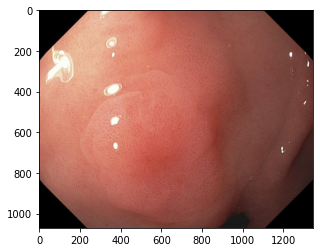

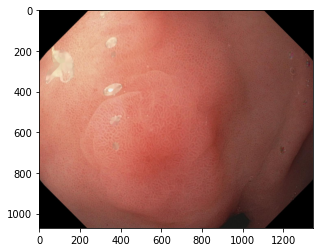

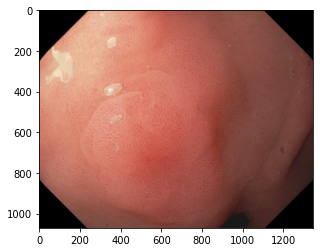

In [ ]:
#specularity removal
import cv2
import numpy as np
import matplotlib.pyplot as plt


impath = '/content/drive/MyDrive/DivergentNets/divergent-nets-main/Kvasir-SEG/images/cju0qoxqj9q6s0835b43399p4.jpg'
img = cv2.imread(impath)
gray_img = derive_graym(impath)

r_img = m_img = np.array(gray_img)

rimg = derive_m(img, r_img)
s_img = derive_saturation(img, rimg)
spec_mask = check_pixel_specularity(rimg, s_img)
enlarged_spec =enlarge_specularity(spec_mask)

# use opencv's inpaint methods to remove specularity
radius = 12 
telea = cv2.inpaint(img, enlarged_spec, radius, cv2.INPAINT_TELEA)
ns = cv2.inpaint(img, enlarged_spec, radius, cv2.INPAINT_NS)
imag = cv2.cvtColor(img, cv2.COLOR_BGR2RGB )
image = cv2.cvtColor(ns, cv2.COLOR_BGR2RGB )
image1 = cv2.cvtColor(telea, cv2.COLOR_BGR2RGB )
plt.imshow(imag)

plt.show()
plt.imshow(image)
plt.show()
plt.imshow(image1)
plt.show()

In [ ]:
#specularity removal
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB )
cv2.imwrite('/content/drive/MyDrive/DivergentNets/divergent-nets-main/speularity removal/image1.jpg',image)

True

In [ ]:
#IOU Calculation
#https://github.com/vlbthambawita/divergent-nets
import torch
from torchvision import transforms
from PIL import Image
SMOOTH = 1e-6

def iou_pytorch(pred: torch.Tensor, gt: torch.Tensor):

    pred = pred.squeeze(1)  
    gt = gt.squeeze(1)
    
    pred = pred.int()
    gt = gt.int()

    intersection = (pred & gt).float().sum((1, 2))  
    union = (pred | gt).float().sum((1, 2))         
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)   
 
    
    return iou
import cv2
#save image

gt = cv2.imread('/content/drive/MyDrive/DivergentNets/divergent-nets-main/Kvasir-SEG/masks/cju0qoxqj9q6s0835b43399p4.jpg',cv2.IMREAD_GRAYSCALE)

thresh = 128
# threshold the image
gt1 = cv2.threshold(gt, thresh, 255, cv2.THRESH_BINARY)[1]
cv2.imwrite('./black-and-white.jpg',gt1)  

pred = cv2.imread('/content/drive/MyDrive/DivergentNets/divergent-nets-main/Speularity/image1_mask.jpg',cv2.IMREAD_GRAYSCALE)

pred1 = cv2.threshold(pred, thresh, 255, cv2.THRESH_BINARY)[1]
cv2.imwrite('./black-and-white1.jpg',pred1)  
convert_tensor = transforms.ToTensor()
s =convert_tensor(pred1)
t = convert_tensor(gt1)
#print(f'type',type(gt))
iou = iou_pytorch(s,t)
print(f'pred',s.shape)
print(f'pred',t.shape)
print(f'iou',iou)


pred torch.Size([1, 1070, 1348])
pred torch.Size([1, 1070, 1348])
iou tensor([0.8449])
